In [1]:
import torch
import torchvision
import numpy as np
from torch import nn

import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
class AE(torch.nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=128
        )
        self.encoder_output_layer = nn.Linear(
            in_features=128, out_features=256
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=256, out_features=256
        )
        self.decoder_output_layer = nn.Linear(
            in_features=256, out_features=kwargs["output_shape"]
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed

In [3]:
with open('inputs_sep.npy', 'rb') as f:
    inputs = np.load(f)
    inputs = inputs[50:200].astype('float32')
    
with open('targets_sep.npy', 'rb') as f:
    targets = np.load(f)
    targets = targets[50:200].astype('float32')

In [4]:
inputs.shape, targets.shape

((150, 60), (150, 800))

In [5]:
timeline_len = targets.shape[0]

In [6]:
timeline_len / 24

6.25

In [7]:
in_dim = inputs.shape[1]
out_dim = targets.shape[1]

In [8]:
inputs_tn = torch.from_numpy(inputs)
targets_tn = torch.from_numpy(targets)

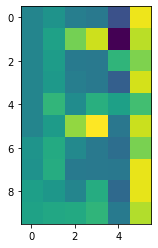

In [9]:
plt.imshow(inputs[0].reshape(10, 6)) 

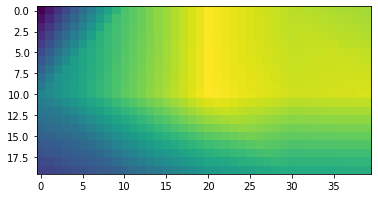

In [10]:
plt.imshow(targets[0].reshape(20, 40)) 

In [15]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_shape=in_dim, output_shape=out_dim).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = torch.nn.MSELoss()

epochs = 25

In [16]:
dataset = torch.utils.data.TensorDataset(inputs_tn, targets_tn)
loader = torch.utils.data.DataLoader(dataset, batch_size=5, shuffle=False)

In [17]:
for epoch in range(epochs):
    loss = 0
    for batch_inputs, batch_targets in loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_inputs = batch_inputs.to(device)
        batch_targets = batch_targets.to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_inputs)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_targets)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(loader)
    
    # display the epoch training loss
    if epoch % 5 == 0:
        print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

epoch : 1/25, loss = 1.544191
epoch : 6/25, loss = 0.784517
epoch : 11/25, loss = 0.781206
epoch : 16/25, loss = 0.661074
epoch : 21/25, loss = 0.692284


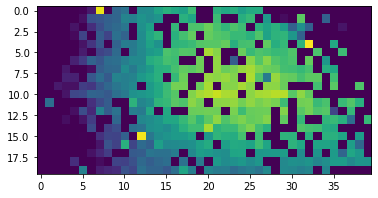

In [18]:
with torch.no_grad():
     rec_img  = model(inputs_tn[0])
        
plt.imshow(rec_img.numpy().reshape(20, 40)) 

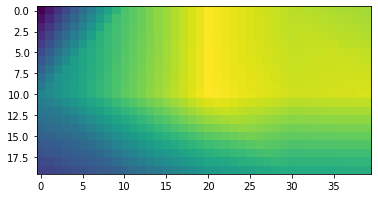

In [19]:
plt.imshow(targets[0].reshape(20, 40)) 

In [20]:
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython import display
import matplotlib.pyplot as plt

fig = plt.figure()

with torch.no_grad():
     rec_img  = model(inputs_tn[0])

im = plt.imshow(rec_img.numpy().reshape(20, 40), animated=True)

def updatefig(frame):
    global x, y
    with torch.no_grad():
         rec_img  = model(inputs_tn[frame])
    im.set_array(rec_img.numpy().reshape(20, 40))
    return im,

#ani = animation.FuncAnimation(fig, updatefig, interval=50, blit=True)
anim_created = FuncAnimation(fig, updatefig, frames=timeline_len, interval=50)    

video = anim_created.to_html5_video()
html = display.HTML(video)
display.display(html)

# good practice to close the plt object.
plt.close()

#anim_created.save('vid.gif')

In [21]:
fig = plt.figure()


im = plt.imshow(targets[0].reshape(20, 40), animated=True)

def updatefig(frame):
    im.set_array(targets[frame].reshape(20, 40))
    return im,

#ani = animation.FuncAnimation(fig, updatefig, interval=50, blit=True)
anim_created = animation.FuncAnimation(fig, updatefig, frames=timeline_len, interval=50)    

video = anim_created.to_html5_video()
html = display.HTML(video)
display.display(html)

# good practice to close the plt object.
plt.close()

#anim_created.save('vid_true.gif')

In [177]:
with torch.no_grad():
    preds = model(inputs_tn).numpy()
          
with open('prediction_sep.npy', 'wb') as f:
    np.save(f, preds) 

In [178]:
dummy_input = torch.randn(60, device="cpu")

In [179]:
input_names = [ "input1" ]
output_names = [ "output1" ]
torch.onnx.export(model, dummy_input, "ae_model.onnx", verbose=True, input_names=input_names, output_names=output_names)

graph(%input1 : Float(60, strides=[1], requires_grad=0, device=cpu),
      %encoder_hidden_layer.bias : Float(128, strides=[1], requires_grad=1, device=cpu),
      %encoder_output_layer.bias : Float(256, strides=[1], requires_grad=1, device=cpu),
      %decoder_hidden_layer.bias : Float(256, strides=[1], requires_grad=1, device=cpu),
      %decoder_output_layer.bias : Float(800, strides=[1], requires_grad=1, device=cpu),
      %25 : Float(60, 128, strides=[1, 60], requires_grad=0, device=cpu),
      %26 : Float(128, 256, strides=[1, 128], requires_grad=0, device=cpu),
      %27 : Float(256, 256, strides=[1, 256], requires_grad=0, device=cpu),
      %28 : Float(256, 800, strides=[1, 256], requires_grad=0, device=cpu)):
  %10 : Float(128, strides=[1], device=cpu) = onnx::MatMul(%input1, %25)
  %11 : Float(128, strides=[1], requires_grad=1, device=cpu) = onnx::Add(%encoder_hidden_layer.bias, %10) # /Users/vprud/Work/air_tracer/venv/lib/python3.7/site-packages/torch/nn/functional.py:1847:0

In [180]:
import onnx

# Load the ONNX model
model = onnx.load("ae_model.onnx")

# Check that the model is well formed
onnx.checker.check_model(model)

# Print a human readable representation of the graph
print(onnx.helper.printable_graph(model.graph))

graph torch-jit-export (
  %input1[FLOAT, 60]
) initializers (
  %encoder_hidden_layer.bias[FLOAT, 128]
  %encoder_output_layer.bias[FLOAT, 256]
  %decoder_hidden_layer.bias[FLOAT, 256]
  %decoder_output_layer.bias[FLOAT, 800]
  %25[FLOAT, 60x128]
  %26[FLOAT, 128x256]
  %27[FLOAT, 256x256]
  %28[FLOAT, 256x800]
) {
  %10 = MatMul(%input1, %25)
  %11 = Add(%encoder_hidden_layer.bias, %10)
  %12 = Relu(%11)
  %14 = MatMul(%12, %26)
  %15 = Add(%encoder_output_layer.bias, %14)
  %16 = Relu(%15)
  %18 = MatMul(%16, %27)
  %19 = Add(%decoder_hidden_layer.bias, %18)
  %20 = Relu(%19)
  %22 = MatMul(%20, %28)
  %23 = Add(%decoder_output_layer.bias, %22)
  %output1 = Relu(%23)
  return %output1
}


In [181]:
import onnxruntime as ort

ort_session = ort.InferenceSession("ae_model.onnx")

outputs = ort_session.run(
    None,
    {"input1": np.random.randn(60).astype(np.float32)},
)
print(outputs[0])

[0.         0.         0.         0.07109512 0.0826107  0.06549507
 0.03434891 0.09142492 0.07252827 0.13953479 0.11220329 0.2172137
 0.1360146  0.1289649  0.15511453 0.14821647 0.1554338  0.16467267
 0.21517873 0.20424542 0.16504632 0.13746503 0.15329722 0.13030203
 0.         0.         0.         0.         0.         0.12989248
 0.         0.         0.15766792 0.         0.         0.
 0.         0.         0.         0.         0.0222357  0.
 0.02564414 0.         0.         0.0992038  0.08289357 0.1295585
 0.12524997 0.14520273 0.08436754 0.24157688 0.21762134 0.21959081
 0.19128177 0.         0.19014168 0.23408762 0.25605756 0.
 0.21693566 0.1699179  0.1484306  0.14345396 0.14084664 0.08625637
 0.17098996 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.0787173
 0.10428378 0.11236729 0.09644706 0.         0.16652524 0.1815401
 0.12076385 0.19950628 0.25326687 0.   